#Experiments

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/MIDAS/train.zip" "/content/train.zip"
!unzip train.zip

In [ ]:
import numpy as np
import torch
import csv
from torch import nn
import pandas as pd
import cv2 as cv
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, ZeroPad2d
from torchvision import transforms
import shutil
from sklearn.metrics import auc, confusion_matrix, classification_report
import seaborn as sns
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import random

In [ ]:
def _preprocess(image):
    # Preprocssing step
    img_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((200, 200)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, ), (0.5,))
    ])
    return img_transform(image)

def _preprocess_aug(image):
  transform_aug = transforms.Compose([
     transforms.ToPILImage(),                                     
     transforms.Resize((200, 200)),                                                        
     transforms.RandomRotation(20),
     #transforms.RandomAffine(0),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5,))
    ])

  return transform_aug(image)

In [ ]:
class Images_train(Dataset):
  def __init__(self, df):
        self.data = df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #print(index)
    image1 = cv.imread(self.data.iloc[index, 0], cv.IMREAD_GRAYSCALE)
    temp=random.randint(0,1)
    if temp == 1:
      image1 = _preprocess_aug(image1)
    else:
      image1 = _preprocess(image1)

    label = self.data.iloc[index, 1]

    return image1, torch.from_numpy(np.array([label], dtype=np.float32))

In [ ]:
class Images_test(Dataset):
  def __init__(self, df):
        self.data = df

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    #print(index)
    image1 = cv.imread(self.data.iloc[index, 0], cv.IMREAD_GRAYSCALE)
    image1 = _preprocess(image1)

    label = self.data.iloc[index, 1]

    return image1, torch.from_numpy(np.array([label], dtype=np.float32))

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/MIDAS/pointOne_cpath.csv")
df = df.sample(frac = 1)
df.head()

,FilePath,Label
362,/content/train/Sample005/img005-042.png,4
1503,/content/train/Sample055/img055-049.png,54
870,/content/train/Sample018/img018-024.png,17
1750,/content/train/Sample062/img062-053.png,61
803,/content/train/Sample020/img020-039.png,19


In [ ]:
df_train, df_valid = train_test_split(df, test_size=0.25)
train_dataset = Images_test(df_train)
valid_dataset = Images_test(df_valid)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)

train_iter = iter(train_loader)
images1, labels = train_iter.next()
print('images shape on batch size = {}'.format(images1.size()))
print('labels shape on batch size = {}'.format(labels.size()))

val_iter = iter(val_loader)
images1, labels = val_iter.next()
print('images shape on batch size = {}'.format(images1.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([8, 1, 200, 200])
labels shape on batch size = torch.Size([8, 1])
images shape on batch size = torch.Size([1, 1, 200, 200])
labels shape on batch size = torch.Size([1, 1])


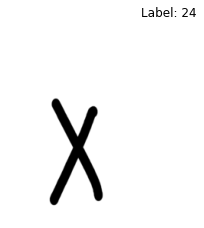

In [ ]:
plt.figure()
plt.subplot(121)
plt.imshow(images1[1][0], cmap="gray")
plt.axis("Off")
plt.suptitle("Label: {}".format(int(labels[0][0])))
plt.show()

In [ ]:
class smallModel(nn.Module):
  def __init__(self):
    super(smallModel, self).__init__()
    
    self.zp1 = nn.ZeroPad2d(1)
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.mp1 = nn.MaxPool2d(kernel_size=2)
    self.dp = nn.Dropout(p=0.3)

    self.zp2 = nn.ZeroPad2d(1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.mp2 = nn.MaxPool2d(kernel_size=2)
    #self.dp = nn.Dropout(p=0.3)

    self.zp3 = nn.ZeroPad2d(1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.mp3 = nn.MaxPool2d(kernel_size=2)

    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
    self.mp4 = nn.MaxPool2d(kernel_size=2)

    self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
    self.mp5 = nn.MaxPool2d(kernel_size=2)

    self.encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8)
    self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=3)

    self.relu = nn.ReLU()

    self.fc1 = nn.Linear(512 * 6 * 6, 9216)
    self.fc2 = nn.Linear(9216, 4096)
    self.fc3 = nn.Linear(4096, 1024)
    self.fc4 = nn.Linear(128 * 25 * 25, 62)

    self.row_emb = nn.Parameter(torch.rand(32, 128 // 2))
    self.col_emb = nn.Parameter(torch.rand(32, 128 // 2))

  def forward(self, x):
    x = self.mp1(self.relu(self.conv1(x)))
    x = self.dp(x)

    x = self.mp2(self.relu(self.conv2(x)))
    x = self.dp(x)

    x = self.mp3(self.relu(self.conv3(x)))
    """x = self.dp(x)

    x = self.mp4(self.relu(self.conv4(x)))
    x = self.dp(x)

    x = self.mp5(self.relu(self.conv5(x)))"""
    #x = self.dp(x)

    H = x.shape[-1]
    W = x.shape[-2]
    pos = torch.cat([self.col_emb[:W].unsqueeze(0).repeat(H, 1, 1), self.row_emb[:H].unsqueeze(1).repeat(1, W, 1),], dim=-1).flatten(0, 1).unsqueeze(1)

    x = x.flatten(2).permute(2, 0, 1)

    x = self.transformer_encoder(pos + x)

    x = x.permute(1, 2, 0)
    x = torch.reshape(x, ((x.shape)[0], 128 * 25 * 25))

    #x = self.relu(self.fc1(x))
    #x = self.relu(self.fc2(x))
    #x = self.relu(self.fc3(x))
    x = self.fc4(x)
  
    return x

In [ ]:
x = torch.rand(1, 200, 200)
x = x.unsqueeze(0)
print(x.shape)

model = smallModel()
model.train()
pred = model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = smallModel().to(device)
print(model)

In [ ]:
def accuracy(out, labels):
    count = 0
    _,pred = torch.max(out, dim=1)
    for i in range(output.shape[0]):
      if pred[i] == labels[i][0]:
        count = count + 1
    return count

In [ ]:
chkpt_path = "/content/drive/MyDrive/MIDAS/Point1/model_encoder.pt"
best_path = "/content/drive/MyDrive/MIDAS/Point1/best_model_encoder.pt"

train_loss_list = []
valid_loss_list = []
train_accuracy = []
valid_accuracy = []

epochs = 10
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay = 1e-4)
criterion = nn.CrossEntropyLoss()
min_valid_loss = np.Inf
check_epoch = 5
epoch_no_improve = 0
i = 0


for epoch in range(1, 30):
  train_loss = 0
  valid_loss = 0
  tcorrect = 0
  vcorrect = 0
  model.train()

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Training: ")
  for batch, (img, target) in enumerate(train_loader):
    #print(batch)
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    optimizer.zero_grad()
    output = model(img)

    loss = criterion(output, target.view(-1))

    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    tcorrect += accuracy(output, target)
    _,pred = torch.max(output, dim=1)
    """print('Pred: ')
    print(pred)
    print('Target: ')
    print(target)"""
  
    
  model.eval()
  print("Validation: ")
  for batch, (img, target) in enumerate(val_loader):
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    output = model(img)
    
    loss = criterion(output, target.view(-1))

    valid_loss += loss.item()
    vcorrect += accuracy(output, target)
    _,pred = torch.max(output, dim=1)
    """print('Pred: ')
    print(pred)
    print('Target: ')
    print(target)"""
    
  # calculate average losses
  train_loss = train_loss/len(train_loader)
  valid_loss = valid_loss/len(val_loader)
  train_loss_list.append(train_loss)
  valid_loss_list.append(valid_loss)

  #tcorrect = tcorrect/(len(train_loader) * 8)
  #vcorrect = vcorrect/len(val_loader)
  train_accuracy.append(tcorrect)
  valid_accuracy.append(vcorrect)
  
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
      epoch, train_loss, tcorrect, valid_loss, vcorrect))
  #print(train_loss_list)
  #print(valid_loss_list)
  
  
  #if epoch % 5 == 0 :
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, chkpt_path)
    
  
  """if valid_loss < min_valid_loss :
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': loss,}, chkpt_path)
    shutil.copyfile(chkpt_path, best_path)
    min_valid_loss = valid_loss
    epoch_no_improve = 0
  else:
    epoch_no_improve = epoch_no_improve + 1"""

Training: 
Validation: 
Epoch: 1 	Training Loss: 4.758856 	Training Accuracy: 286.000000 	Validation Loss: 4.456472 	Validation Accuracy: 10.000000
Training: 
Validation: 
Epoch: 2 	Training Loss: 4.417442 	Training Accuracy: 194.000000 	Validation Loss: 4.432405 	Validation Accuracy: 7.000000
Training: 
Validation: 
Epoch: 3 	Training Loss: 4.352081 	Training Accuracy: 231.000000 	Validation Loss: 4.364543 	Validation Accuracy: 7.000000
Training: 
Validation: 
Epoch: 4 	Training Loss: 4.339611 	Training Accuracy: 235.000000 	Validation Loss: 4.316694 	Validation Accuracy: 9.000000
Training: 
Validation: 
Epoch: 5 	Training Loss: 4.306518 	Training Accuracy: 276.000000 	Validation Loss: 4.303569 	Validation Accuracy: 11.000000
Training: 
Validation: 
Epoch: 6 	Training Loss: 4.288569 	Training Accuracy: 208.000000 	Validation Loss: 4.351682 	Validation Accuracy: 12.000000
Training: 
Validation: 
Epoch: 7 	Training Loss: 4.277458 	Training Accuracy: 194.000000 	Validation Loss: 4.304969

In [ ]:
chkpt_path = "/content/drive/MyDrive/MIDAS/Point1/model_encoder2.pt"
best_path = "/content/drive/MyDrive/MIDAS/Point1/best_model_encoder2.pt"

train_loss_list = []
valid_loss_list = []
train_accuracy = []
valid_accuracy = []

epochs = 10
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
min_valid_loss = np.Inf
check_epoch = 5
epoch_no_improve = 0
i = 0


for epoch in range(1, 30):
  train_loss = 0
  valid_loss = 0
  tcorrect = 0
  vcorrect = 0
  model.train()

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Training: ")
  for batch, (img, target) in enumerate(train_loader):
    #print(batch)
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    optimizer.zero_grad()
    output = model(img)

    loss = criterion(output, target.view(-1))

    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    pred = accuracy(output, target)
    tcorrect += pred
    #_,pred = torch.max(output, dim=1)
    """print('Pred: ')
    print(pred)
    print('Target: ')
    print(target)
    print('Output: ')
    print(torch.max(output, dim=1))
    if pred == 10:
      break"""
  
    
  model.eval()
  print("Validation: ")
  for batch, (img, target) in enumerate(val_loader):
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    output = model(img)
    
    loss = criterion(output, target.view(-1))

    valid_loss += loss.item()
    vcorrect += accuracy(output, target)
    _,pred = torch.max(output, dim=1)
    """print('Pred: ')
    print(pred)
    print('Target: ')
    print(target)"""
    
  # calculate average losses
  train_loss = train_loss/len(train_loader)
  valid_loss = valid_loss/len(val_loader)
  train_loss_list.append(train_loss)
  valid_loss_list.append(valid_loss)

  tcorrect = tcorrect/(len(train_loader) * 8)
  vcorrect = vcorrect/len(val_loader)
  train_accuracy.append(tcorrect)
  valid_accuracy.append(vcorrect)
  
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
      epoch, train_loss, tcorrect, valid_loss, vcorrect))
  #print(train_loss_list)
  #print(valid_loss_list)
  
  
  #if epoch % 5 == 0 :
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, chkpt_path)
    
  
  """if valid_loss < min_valid_loss :
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': loss,}, chkpt_path)
    shutil.copyfile(chkpt_path, best_path)
    min_valid_loss = valid_loss
    epoch_no_improve = 0
  else:
    epoch_no_improve = epoch_no_improve + 1"""

Training: 
Validation: 
Epoch: 1 	Training Loss: 4.809451 	Training Accuracy: 0.017704 	Validation Loss: 4.411512 	Validation Accuracy: 0.017742
Training: 
Validation: 
Epoch: 2 	Training Loss: 4.421627 	Training Accuracy: 0.016094 	Validation Loss: 4.315686 	Validation Accuracy: 0.025806
Training: 
Validation: 
Epoch: 3 	Training Loss: 4.353073 	Training Accuracy: 0.012339 	Validation Loss: 4.333647 	Validation Accuracy: 0.014516
Training: 
Validation: 
Epoch: 4 	Training Loss: 4.330454 	Training Accuracy: 0.011803 	Validation Loss: 4.310827 	Validation Accuracy: 0.020968
Training: 
Validation: 
Epoch: 5 	Training Loss: 4.280544 	Training Accuracy: 0.009657 	Validation Loss: 4.307467 	Validation Accuracy: 0.017742
Training: 
Validation: 
Epoch: 6 	Training Loss: 4.273489 	Training Accuracy: 0.016094 	Validation Loss: 4.271833 	Validation Accuracy: 0.017742
Training: 
Validation: 
Epoch: 7 	Training Loss: 4.264450 	Training Accuracy: 0.016631 	Validation Loss: 4.304839 	Validation Accu

KeyboardInterrupt: ignored

In [ ]:
chkpt_path = "/content/drive/MyDrive/MIDAS/Point1/model_encoder3.pt"
best_path = "/content/drive/MyDrive/MIDAS/Point1/best_model_encoder3.pt"

train_loss_list = []
valid_loss_list = []
train_accuracy = []
valid_accuracy = []

epochs = 10
optimizer = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
min_valid_loss = np.Inf
check_epoch = 5
epoch_no_improve = 0
i = 0


for epoch in range(1, 30):
  train_loss = 0
  valid_loss = 0
  tcorrect = 0
  vcorrect = 0
  model.train()

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print("Training: ")
  for batch, (img, target) in enumerate(train_loader):
    #print(batch)
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    optimizer.zero_grad()
    output = model(img)

    loss = criterion(output, target.view(-1))

    loss.backward()
    optimizer.step()

    train_loss += loss.item()

    pred = accuracy(output, target)
    tcorrect += pred
    #_,pred = torch.max(output, dim=1)
    """print('Pred: ')
    print(pred)
    print('Target: ')
    print(target)
    print('Output: ')
    print(torch.max(output, dim=1))
    if pred == 10:
      break"""
  
    
  model.eval()
  print("Validation: ")
  for batch, (img, target) in enumerate(val_loader):
    if torch.cuda.is_available():
        img, target = img.to(device=device, dtype=torch.float), target.to(device=device, dtype=torch.long)

    output = model(img)
    
    loss = criterion(output, target.view(-1))

    valid_loss += loss.item()
    vcorrect += accuracy(output, target)
    _,pred = torch.max(output, dim=1)
    """print('Pred: ')
    print(pred)
    print('Target: ')
    print(target)"""
    
  # calculate average losses
  train_loss = train_loss/len(train_loader)
  valid_loss = valid_loss/len(val_loader)
  train_loss_list.append(train_loss)
  valid_loss_list.append(valid_loss)

  tcorrect = tcorrect/(len(train_loader) * 8)
  vcorrect = vcorrect/len(val_loader)
  train_accuracy.append(tcorrect)
  valid_accuracy.append(vcorrect)
  
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
      epoch, train_loss, tcorrect, valid_loss, vcorrect))
  #print(train_loss_list)
  #print(valid_loss_list)
  
  
  #if epoch % 5 == 0 :
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, chkpt_path)
    
  
  """if valid_loss < min_valid_loss :
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(), 'loss': loss,}, chkpt_path)
    shutil.copyfile(chkpt_path, best_path)
    min_valid_loss = valid_loss
    epoch_no_improve = 0
  else:
    epoch_no_improve = epoch_no_improve + 1"""

Training: 
Validation: 
Epoch: 1 	Training Loss: 6.687986 	Training Accuracy: 0.019850 	Validation Loss: 5.165957 	Validation Accuracy: 0.022581
Training: 
Validation: 
Epoch: 2 	Training Loss: 5.092049 	Training Accuracy: 0.023069 	Validation Loss: 5.135393 	Validation Accuracy: 0.016129
Training: 
Validation: 
Epoch: 3 	Training Loss: 4.293870 	Training Accuracy: 0.099249 	Validation Loss: 4.083165 	Validation Accuracy: 0.138710
Training: 
Validation: 
Epoch: 4 	Training Loss: 3.087020 	Training Accuracy: 0.296674 	Validation Loss: 3.633912 	Validation Accuracy: 0.245161
Training: 
Validation: 
Epoch: 5 	Training Loss: 2.674966 	Training Accuracy: 0.352468 	Validation Loss: 3.533776 	Validation Accuracy: 0.243548
Training: 
Validation: 
Epoch: 6 	Training Loss: 2.243886 	Training Accuracy: 0.442060 	Validation Loss: 3.459770 	Validation Accuracy: 0.303226
Training: 
Validation: 
Epoch: 7 	Training Loss: 1.851914 	Training Accuracy: 0.510193 	Validation Loss: 3.343628 	Validation Accu

KeyboardInterrupt: ignored

In [ ]:
output.shape
_,predic = torch.max(output, dim=1)
predic

tensor([17, 47, 26, 31, 30, 16, 26, 48], device='cuda:0')

In [ ]:
target


tensor([[17],
        [47],
        [26],
        [31],
        [30],
        [16],
        [26],
        [48]], device='cuda:0')

In [ ]:
accuracy(output, target)

8

In [ ]:
x = torch.tensor([17, 24, 26, 31, 30, 16, 26, 48])
y = torch.tensor([[17], [24], [27], [31], [30], [16], [26], [48]])
x == y

tensor([[ True, False, False, False, False, False, False, False],
        [False,  True, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False, False],
        [False, False, False, False,  True, False, False, False],
        [False, False, False, False, False,  True, False, False],
        [False, False,  True, False, False, False,  True, False],
        [False, False, False, False, False, False, False,  True]])

In [ ]:
df_valid.shape

(620, 2)

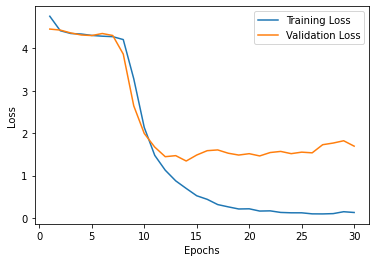

In [ ]:
#Without Augmentation
a = [i for  i in range(1, 31)]
plt.plot(a, train_loss_list, label = 'Training Loss')
plt.plot(a, valid_loss_list, label = 'Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

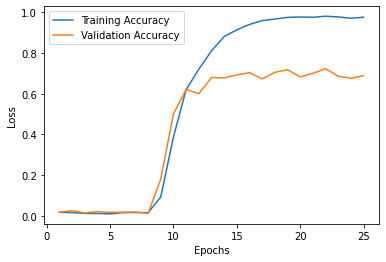

In [ ]:
#Without Augmentation
a = [i for  i in range(1, 26)]
plt.plot(a, train_accuracy, label = 'Training Accuracy')
plt.plot(a, valid_accuracy, label = 'Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [ ]:
output.shape

NameError: ignored

In [ ]:
accuracy(output, target)

4

In [ ]:
torch.randn(10, 120).float().shape

torch.Size([10, 120])

In [ ]:
x.shape

torch.Size([1, 1, 200, 200])